In [195]:
import sys
import heapq
import numpy as np
from copy import copy

import pandas as pd
from sklearn import tree, metrics



# sys.setrecursionlimit(sys.maxunicode)


class Spade:

    def __init__(self, pos_filepath, neg_filepath, k):

        self.pos_transactions, self.P = spade_repr_from_transaction(get_transactions(pos_filepath))
        self.pos_transactions_repr = self.pos_transactions['repr']
        self.pos_transactions_cover = self.pos_transactions['covers']

        self.neg_transactions, self.N = spade_repr_from_transaction(get_transactions(neg_filepath), self.P)
        self.neg_transactions_repr = self.neg_transactions['repr']
        self.neg_transactions_cover = self.neg_transactions['covers']

        self.k = k

        self.top_k_patterns = None



    # Feel free to add parameters to this method
    def min_top_k(self):
        k=self.k

        D = self.pos_transactions_repr.copy()
        # print(D)
        for j, transaction in self.neg_transactions_repr.items():
            try:
                D[j].update(transaction)
            except:
                D[j] = transaction

        # print(D)

        frequent_sequences = []
        P = {}

        heapq.heapify(frequent_sequences)
        min_support = 1

        for s in D:
            heapq.heappush(frequent_sequences, (len(D[s]),s,D[s]))
            P[s] = D[s]
            # print(frequent_sequences)
            # print(min_support)

        nb_exces_sequences = len(frequent_sequences)-k if len(frequent_sequences)-k > 0 else 0

        # print(P)
        # print(nb_exces_sequences)

        while frequent_sequences[nb_exces_sequences-1][0] == frequent_sequences[nb_exces_sequences][0]:
            nb_exces_sequences -=1
            if nb_exces_sequences < 0:
                break

        while nb_exces_sequences > 0:
            unfrequent = heapq.heappop(frequent_sequences)
            if unfrequent[1] in P:
                P.pop(unfrequent[1])
            nb_exces_sequences-=1

            min_support = frequent_sequences[0][0]

        # print(frequent_sequences)

        get_frequent_sequences(P, k, min_support, frequent_sequences)

        elements = [heapq.heappop(frequent_sequences) for j in range(len(frequent_sequences)) ]
        return ({j[1]:set(j[2].keys()) for j in elements}, self.P) # -> return un tuple, le premier element ce sera tj {"nom_pattern":{transactions_id}}, le deuxième élément ce sera nb transaction positive


    def convert_dict_to_np_array(self, patterns_in_trans):
        """
        Convert a dictionary of patterns to a NumPy array where each row represents a transaction and each column represents a pattern.
        """

        # Get all unique transactions
        all_transactions = set()
        for transactions in patterns_in_trans.values():
            all_transactions.update(transactions)

        # Create an empty NumPy array with dimensions (number of transactions, number of unique patterns)
        num_transactions = self.P + self.N
        num_patterns = len(patterns_in_trans)
        np_array = np.zeros((num_transactions, num_patterns))

        # Create a mapping from pattern to column index in the array
        pattern_to_col_index = {pattern: i for i, pattern in enumerate(patterns_in_trans.keys())}

        # Iterate over each pattern and its associated transactions
        for pattern, transactions in patterns_in_trans.items():
            col_index = pattern_to_col_index[pattern]
            for transaction in transactions:
                row_index = list(all_transactions).index(transaction)
                np_array[row_index, col_index] = 1

        return np_array

    def get_feature_matrices(self, best_patterns, train_set_ids):
        """
        Assuming we know the top-k best patterns and the presence of each of them in the transactions (self.pos_features_matrix and self.neg_features_matrix).
        This method should return the feature matrices and the labels for the training and testing sets w.r.t the ids of the transactions in the training set.
        """

        # Convert the self.pos_patterns_in_trans and self.pos_patterns_in_trans into numpy arrays
        feat_matrix = self.convert_dict_to_np_array(best_patterns)

        # Input Matrices
        train_matrix = feat_matrix[train_set_ids]
        test_matrix = np.delete(feat_matrix, train_set_ids, axis=0)

        # Output Labels
        train_nb_pos_label = np.sum(train_set_ids < self.P)
        train_nb_neg_label = np.sum(train_set_ids >= self.P)
        train_labels = np.concatenate((np.ones(train_nb_pos_label), np.zeros(train_nb_neg_label)))
        test_labels = np.concatenate((np.ones(self.P - train_nb_pos_label), np.zeros(self.N - train_nb_neg_label)))

        return {
            'train_matrix': train_matrix,
            'test_matrix': test_matrix,
            'train_labels': train_labels,
            'test_labels': test_labels,
        }

    def cross_validation(self, nfolds, best_patterns=None):
        accuracy = []

        pos_fold_size = self.P // nfolds
        neg_fold_size = self.N // nfolds
        for fold in range(nfolds):
            print('fold {}'.format(fold + 1))
            pos_train_set_ids = np.array([i for i in range(self.P) if
                                 i < fold * pos_fold_size or i >= (fold + 1) * pos_fold_size])
            neg_train_set_ids = np.array([self.P + i for i in range(self.N) if
                                 i < fold * neg_fold_size or i >= (fold + 1) * neg_fold_size])
            train_set_ids = np.concatenate((pos_train_set_ids, neg_train_set_ids))

            if best_patterns is None:
                self.top_k_patterns = self.min_top_k()[0]
                m = self.get_feature_matrices(self.top_k_patterns, train_set_ids)
            else:
                m = self.get_feature_matrices(best_patterns, train_set_ids)

            classifier = tree.DecisionTreeClassifier(random_state=1)
            classifier.fit(m['train_matrix'], m['train_labels'])
            #print(classifier.feature_importances_)

            predicted = classifier.predict(m['test_matrix'])
            accuracy.append(metrics.accuracy_score(m['test_labels'], predicted))
            print(f'Accuracy: {accuracy[-1]}')

        return accuracy

def get_transactions(filepath):
    transactions = []
    with open(filepath) as f:
        new_transaction = True
        for line in f:
            if line.strip():
                if new_transaction:
                    transactions.append([])
                    new_transaction = False
                element = line.split(" ")
                assert(int(element[1]) - 1 == len(transactions[-1]))
                transactions[-1].append(element[0])
            else:
                new_transaction = True
    return transactions

def spade_repr_from_transaction(transactions, min_id=0):
    spade_repr = {}
    covers = {}
    for tid, transaction in enumerate(transactions):
        tid+=min_id
        for i, item in enumerate(transaction):
            try:
                covers[item].add(tid)
            except KeyError:
                covers[item] = {tid}
            try:
                spade_repr[item][tid].append(i)
            except KeyError:
                try:
                    spade_repr[item][tid] = [i]
                except KeyError:
                    spade_repr[item] = {tid:[i]}

    return {'repr': spade_repr, 'covers': covers}, tid-min_id+1



def get_frequent_sequences(P, top_k, min_support, frequent_sequences):
    # print(len(frequent_sequences))
    # print(P)
    unfrequent_P = set()
    for ra in P:
        if ra in unfrequent_P:
            continue
        Pa = {}
        if len(frequent_sequences)<k:
            min_support = 1
        else:
            min_support = heapq.nsmallest(1, frequent_sequences)[0][0]
        for rb in P:
            if rb in unfrequent_P:
                continue

            rab, P_rab = intersect(ra, rb, P)

            if len(P_rab)>=min_support:
                heapq.heappush(frequent_sequences, (len(P_rab),rab,P_rab))
                Pa[rab] = P_rab
        if Pa:
            nb_exces_sequences = len(frequent_sequences)-k if len(frequent_sequences)-k > 0 else 0

            n_smallest = heapq.nsmallest(nb_exces_sequences+1, frequent_sequences)

            while n_smallest[nb_exces_sequences-1][0] == n_smallest[nb_exces_sequences][0]:
                nb_exces_sequences -=1
                if nb_exces_sequences < 0:
                    break
            while nb_exces_sequences > 0:
                unfrequent = heapq.heappop(frequent_sequences)
                if unfrequent[1] in Pa:
                    Pa.pop(unfrequent[1])
                if unfrequent[1] in P:
                    unfrequent_P.add(unfrequent[1])
                nb_exces_sequences-=1
            if Pa: get_frequent_sequences(Pa, top_k, min_support, frequent_sequences)
    return frequent_sequences


def intersect(ra, rb, P):
    rab = ra + "-" + rb.split("-")[-1]
    #rab = ra+rb[-1]
    transaction_in_common_ids = P[ra].keys()&P[rb].keys()
    P_rab = {}
    for t_id in transaction_in_common_ids:
        pos_a = P[ra][t_id][0]
        position_list_ab = [pos_b for pos_b in P[rb][t_id] if pos_b>pos_a]
        if position_list_ab:
            P_rab[t_id] = position_list_ab

    return rab, P_rab


def weighted_relative_accuracy(P, N, transactions_containing_pattern):

    p = sum([i <= P for i in transactions_containing_pattern])
    n = len(transactions_containing_pattern)-p
    # print(P)
    # print(N)
    return (P/(P+N))*(N/(P+N))*(p/P-n/N)

def weighted_relative_accuracy(P, N, transactions_containing_pattern):

    p = sum([i <= P for i in transactions_containing_pattern])
    n = len(transactions_containing_pattern)-p
    # print(P)
    # print(N)
    return (p+n)/(P+N) * (p/(p+n) - P/(P+N))



# Spade Algorithm

In [2]:

pos_filepath = "datasets/Protein/PKA_group15.txt"
neg_filepath = "datasets/Protein/SRC1521.txt"


#pos_filepath = "datasets/Reuters_small/acq_small.txt"
#neg_filepath = "datasets/Reuters_small/earn_small.txt"


# Create the object
k = 30
s = Spade(pos_filepath, neg_filepath, k)


In [3]:

accuracy = s.cross_validation(5)

fold 1
Accuracy: 0.8985507246376812
fold 2
Accuracy: 0.9057971014492754
fold 3
Accuracy: 0.8985507246376812
fold 4
Accuracy: 0.9202898550724637
fold 5
Accuracy: 0.9057971014492754


## Accuracy as a function of k

In [330]:
acc_by_k = pd.DataFrame(columns=['k', 'mean_accuracy', 'std_accuracy'])

accuracy = s.cross_validation(5)
acc_by_k.loc[0] = [k, np.mean(accuracy), np.std(accuracy)]

remaining_patterns = copy(s.top_k_patterns)
for i in range(len(s.top_k_patterns)-1):
    remaining_patterns.pop(list(remaining_patterns.keys())[0])

    accuracy = s.cross_validation(5, best_patterns=remaining_patterns)
    acc_by_k.loc[i+1] = [k-i-1, np.mean(accuracy), np.std(accuracy)]

    print(f"Accuracy for k={k-i-1}: {np.mean(accuracy)}")




fold 1
Accuracy: 0.8985507246376812
fold 2
Accuracy: 0.9057971014492754
fold 3
Accuracy: 0.8985507246376812
fold 4
Accuracy: 0.9202898550724637
fold 5
Accuracy: 0.9057971014492754
fold 1
Accuracy: 0.9130434782608695
fold 2
Accuracy: 0.9057971014492754
fold 3
Accuracy: 0.9057971014492754
fold 4
Accuracy: 0.9347826086956522
fold 5
Accuracy: 0.8985507246376812
Accuracy for k=29: 0.9115942028985508
fold 1
Accuracy: 0.9130434782608695
fold 2
Accuracy: 0.9057971014492754
fold 3
Accuracy: 0.927536231884058
fold 4
Accuracy: 0.9492753623188406
fold 5
Accuracy: 0.8695652173913043
Accuracy for k=28: 0.9130434782608697
fold 1
Accuracy: 0.9130434782608695
fold 2
Accuracy: 0.9057971014492754
fold 3
Accuracy: 0.8913043478260869
fold 4
Accuracy: 0.8985507246376812
fold 5
Accuracy: 0.8478260869565217
Accuracy for k=27: 0.8913043478260869
fold 1
Accuracy: 0.9347826086956522
fold 2
Accuracy: 0.927536231884058
fold 3
Accuracy: 0.855072463768116
fold 4
Accuracy: 0.9347826086956522
fold 5
Accuracy: 0.862318

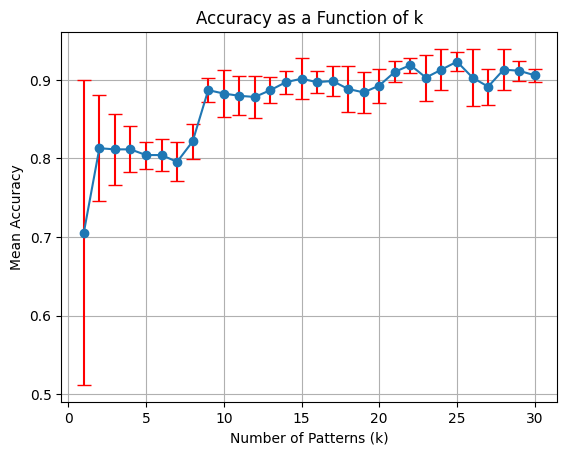

In [331]:
import matplotlib.pyplot as plt


# Extract data from DataFrame
k_values = acc_by_k['k']
mean_accuracy_values = acc_by_k['mean_accuracy']
std_accuracy_values = acc_by_k['std_accuracy']

# Plot accuracy as a function of k with error bars
plt.errorbar(k_values, mean_accuracy_values, yerr=std_accuracy_values, fmt='o-', ecolor='red', capsize=5)
plt.title('Accuracy as a Function of k')
plt.xlabel('Number of Patterns (k)')
plt.ylabel('Mean Accuracy')
plt.grid(True)
plt.show()


## Discrimative power of the patterns for the Spade algorithm

In [348]:


print(f"Percentage of positive transactions in the dataset: {np.round(s.P/(s.P+s.N), 3)}")
for patt in s.top_k_patterns:
    print("====================================")
    print(f"Pattern '{patt}' is present in {len(s.top_k_patterns[patt])} transactions")
    perc_of_pos = np.round(np.sum([(i<s.P) for i in s.top_k_patterns[patt]])/len(s.top_k_patterns[patt]), 3)
    perc_of_neg = np.round(1 - perc_of_pos, 3)
    print(f"Percentage of positive transactions containing the pattern {patt}: {perc_of_pos:.2%}")
    print(f"Percentage of negative transactions containing the pattern {patt}: {perc_of_neg:.2%}")




Percentage of positive transactions in the dataset: 0.548
Pattern 'S-P' is present in 255 transactions
Percentage of positive transactions containing the pattern S-P: 51.40%
Percentage of negative transactions containing the pattern S-P: 48.60%
Pattern 'S-G' is present in 256 transactions
Percentage of positive transactions containing the pattern S-G: 53.10%
Percentage of negative transactions containing the pattern S-G: 46.90%
Pattern 'L-S' is present in 258 transactions
Percentage of positive transactions containing the pattern L-S: 62.80%
Percentage of negative transactions containing the pattern L-S: 37.20%
Pattern 'S-V' is present in 260 transactions
Percentage of positive transactions containing the pattern S-V: 55.00%
Percentage of negative transactions containing the pattern S-V: 45.00%
Pattern 'A-S' is present in 262 transactions
Percentage of positive transactions containing the pattern A-S: 60.30%
Percentage of negative transactions containing the pattern A-S: 39.70%
Pattern

# No Mining (only single symbols)

In [166]:

# Create the object
k = 1
s = Spade(pos_filepath, neg_filepath, k)


transactions_cover = s.pos_transactions_cover.copy()

for patt in s.pos_transactions_cover:
    if patt in s.neg_transactions_cover:
        transactions_cover[patt] = (s.pos_transactions_cover[patt] | s.neg_transactions_cover[patt])

for patt in s.neg_transactions_cover:
    if patt not in s.pos_transactions_cover:
        transactions_cover[patt] = s.neg_transactions_cover[patt]

accuracy = s.cross_validation(5, transactions_cover)



fold 1
Accuracy: 0.8768115942028986
fold 2
Accuracy: 0.8840579710144928
fold 3
Accuracy: 0.8478260869565217
fold 4
Accuracy: 0.8913043478260869
fold 5
Accuracy: 0.8623188405797102


In [167]:
print(np.mean(accuracy), np.std(accuracy))

0.872463768115942 0.015609173354013047


## Discrimative power of the patterns for the single symbol

In [168]:
print(f"Percentage of positive transactions in the dataset: {np.round(s.P/(s.P+s.N), 3)}")
for patt in transactions_cover:
    print("====================================")
    print(f"Pattern '{patt}' is present in {len(transactions_cover[patt])} transactions")

    wra = weighted_relative_accuracy(s.P, s.N, transactions_cover[patt])
    print(f"Weighted Relative Accuracy: {wra}")
    perc_of_pos = np.sum([(i<s.P) for i in transactions_cover[patt]])/len(transactions_cover[patt])
    perc_of_neg = 1 - perc_of_pos
    print(f"--> Percentage of positive transactions containing the pattern '{patt}': {perc_of_pos:.2%}")
    print(f"--> Percentage of negative transactions containing the pattern '{patt}': {perc_of_neg:.2%}")



Percentage of positive transactions in the dataset: 0.548
Pattern 'W' is present in 77 transactions
Weighted Relative Accuracy: -0.013253972361679
--> Percentage of positive transactions containing the pattern 'W': 42.86%
--> Percentage of negative transactions containing the pattern 'W': 57.14%
Pattern 'K' is present in 379 transactions
Weighted Relative Accuracy: 0.019038352052171213
--> Percentage of positive transactions containing the pattern 'K': 58.05%
--> Percentage of negative transactions containing the pattern 'K': 41.95%
Pattern 'A' is present in 442 transactions
Weighted Relative Accuracy: 0.0024387971637079013
--> Percentage of positive transactions containing the pattern 'A': 54.98%
--> Percentage of negative transactions containing the pattern 'A': 45.02%
Pattern 'L' is present in 461 transactions
Weighted Relative Accuracy: 0.00327933336783812
--> Percentage of positive transactions containing the pattern 'L': 55.10%
--> Percentage of negative transactions containing t

# Sequential Covering Algorithm

In [259]:


def remove_covered_transactions(dataset : Spade, pattern_cover):
    """
    Remove the transactions covered by the pattern
    :param dataset: Spade object
    :param pattern: pattern
    :return: Spade object
    """
    remaining_transactions = copy(dataset)

    patt_text = list(pattern_cover.keys())[0]
    trans_to_remove = pattern_cover[patt_text]

    n = p = 0

    # Remove the positive transactions covered by the pattern
    if patt_text in remaining_transactions.pos_transactions_cover:
        p = len(remaining_transactions.pos_transactions_cover[patt_text])
        filtered_pos_transactions_cover = {}
        filtered_pos_transactions_repr = {}
        for key, value in remaining_transactions.pos_transactions_cover.items():
            filtered_trans = value - trans_to_remove

            if filtered_trans:
                filtered_pos_transactions_cover[key] = filtered_trans
                filtered_pos_transactions_repr[key] = {key: value for key, value in remaining_transactions.pos_transactions_repr[key].items()
                                                       if key in filtered_trans}

        remaining_transactions.pos_transactions_cover = filtered_pos_transactions_cover
        remaining_transactions.pos_transactions_repr = filtered_pos_transactions_repr

        # Update the number of transactions
        remaining_transactions.P -= p

    # Remove the negative transactions covered by the pattern
    if patt_text in remaining_transactions.neg_transactions_cover:
        n = len(remaining_transactions.neg_transactions_cover[patt_text])
        filtered_neg_transactions_cover = {}
        filtered_neg_transactions_repr = {}
        for key, value in remaining_transactions.neg_transactions_cover.items():
            filtered_trans = value - trans_to_remove

            if filtered_trans:
                filtered_neg_transactions_cover[key] = filtered_trans
                filtered_neg_transactions_repr[key] = {key: value for key, value in remaining_transactions.neg_transactions_repr[key].items() if key in filtered_trans}

        remaining_transactions.neg_transactions_cover = filtered_neg_transactions_cover
        remaining_transactions.neg_transactions_repr = filtered_neg_transactions_repr

        # Update the number of transactions
        remaining_transactions.N -= n

    return remaining_transactions, int(p > n)




def SequentialCoveringAlgorithm(dataset : Spade, k):
    """
    Sequential Covering Algorithm
    :param dataset: list of transactions
    :param k: number of patterns to be mined
    :param metric: metric to be used to evaluate the patterns
    :param min_support: minimum support threshold
    :return: list of patterns
    """
    remaining_transactions = dataset

    patterns_rules = {}
    for i in range(k):
        # Find the best pattern
        best_pattern = remaining_transactions.min_top_k()


        patterns_text = list(best_pattern[0].keys())[0]

        # Remove the transactions covered by the best pattern and store the rule
        remaining_transactions, patterns_rules[patterns_text] = remove_covered_transactions(remaining_transactions, best_pattern[0])

        if remaining_transactions.P == 0 and remaining_transactions.N == 0:
            print("No more transactions to mine")
            break

    final_class = 1 if remaining_transactions.P > remaining_transactions.N else 0

    return patterns_rules, final_class

In [268]:
def SequentialCoveringAlgorithmPredict(transaction, pattern_rules, final_class):
    """
    Predict the class of a transaction
    :param transaction: list of items in the transaction
    :param pattern_rules: Class of the pattern if the pattern is present in the transaction
    :param final_class: Class of the transaction if no pattern is present in the transaction
    :return:
    """
    pred = final_class
    for patt in pattern_rules:
        if patt in transaction:
            pred = pattern_rules[patt]
            return pred
    return pred

In [269]:

pos_filepath = "datasets/Protein/PKA_group15.txt"
neg_filepath = "datasets/Protein/SRC1521.txt"

pos_filepath = "datasets/Reuters_small/acq_small.txt"
neg_filepath = "datasets/Reuters_small/earn_small.txt"

# Create the object
k = 1
s = Spade(pos_filepath, neg_filepath, k)



In [266]:
sol = SequentialCoveringAlgorithm(s, 20)

In [262]:
sol

({'reuter': 0,
  'dlr': 1,
  'ct': 0,
  'shr': 0,
  'for': 1,
  'profit': 0,
  'bid': 1,
  'and': 1,
  'pct': 1,
  'intern': 1,
  'group': 1,
  'unit': 1,
  'share': 1,
  'see': 0,
  'sale': 1,
  'inc': 1,
  'talk': 1,
  'action': 1,
  'sell': 1,
  'acquir': 1},
 1)

In [276]:
# Test the algorithm on the positive transactions
res = []
for i in range(200):
    test = get_transactions(neg_filepath)[i]
    pred = SequentialCoveringAlgorithmPredict(test, sol[0], sol[1])
    res.append(pred)

res = np.array(res)
np.unique(res, return_counts=True)

(array([0, 1]), array([195,   5], dtype=int64))

* Remove the pattern in the feature matrix then convert the matrix into a dictionary
* Keep the first pattern in the lexicographic order